In [44]:
import networkx as nx


import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": True, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})
USE_TEX = False
if USE_TEX:
    plt.rc("text", usetex=True)
    plt.rc("text.latex", preamble=r"""
     \usepackage{times}
     \usepackage{mathptmx}""")
else:
    plt.rc("text", usetex=False)
plt.rc("font", family="serif")

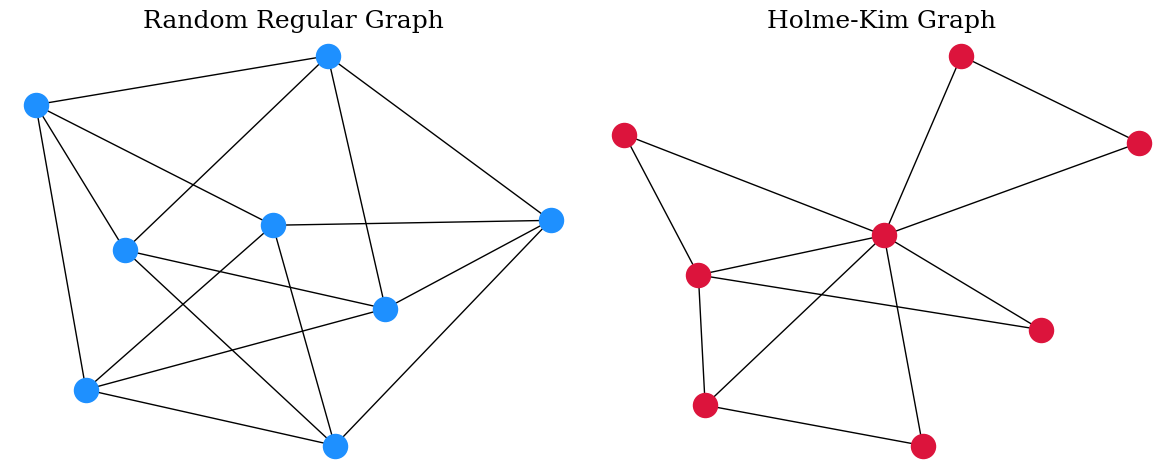

In [181]:
N = 8
#G1 = nx.random_regular_graph(n=N, d=4)
G2 = nx.powerlaw_cluster_graph(n=N, m=2, p=0.5)

titles = ["Random Regular Graph", "Holme-Kim Graph"]

fig, axs = plt.subplots(1,2, figsize=(12,5))
nx.draw_kamada_kawai(G1, ax=axs[0], node_color="dodgerblue")
axs[0].set_title(titles[0])
nx.draw_kamada_kawai(G2, ax=axs[1], node_color="crimson")
axs[1].set_title(titles[1])

fig.tight_layout()
plt.savefig("../figures/sample_graphs.pdf", bbox_inches="tight")